In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import warnings

from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

import category_encoders as ce
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from imblearn.under_sampling import RandomUnderSampler


warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)


### Cargar fichero

In [2]:
df_fraud = pd.read_csv("../data/Base.csv")
df_fraud.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,10650.765523,3134.319630,3863.647740,1,6,CA,185,0,BA,1,0,24,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,534.047319,2670.918292,3124.298166,718,3,CA,259,1,BA,0,0,15,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,4048.534263,2893.621498,3159.590679,1,14,CB,177,1,BA,0,1,-1,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,3457.064063,4054.908412,3022.261812,1921,6,CA,110,1,BA,0,1,31,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,5020.341679,2728.237159,3087.670952,1990,2,CA,295,1,BA,1,0,31,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


### Target encoding

Elegimos la codificación con target encoding para aquellas variables que consideramos que son ordenables. En este caso, como son estatus, es fácil colocarlos por orden.

In [3]:
# Codificiamos las variables que son ordenables con target encoding
mapeo_housing_status = {'BA': 1, 'BB': 2, 'BC': 3, 'BD': 4, 'BE': 5, 'BF': 6, 'BG': 7}
mapeo_payment_type = {'AA': 1, 'AB': 2, 'AC': 3, 'AD': 4, 'AE': 5}
mapeo_employment_status = {'CA': 1, 'CB': 2, 'CC': 3, 'CD': 4, 'CE': 5, 'CF': 6, 'CG': 7}

# Sobrescrimos las columnas originales con los valores codificados
df_fraud['housing_status'] = df_fraud['housing_status'].map(mapeo_housing_status)
df_fraud['payment_type'] = df_fraud['payment_type'].map(mapeo_payment_type)
df_fraud['employment_status'] = df_fraud['employment_status'].map(mapeo_employment_status)
df_fraud.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                          int64
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                     int64
credit_risk_score                     int64
email_is_free                         int64
housing_status                        int64
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

### One hot encoding

Ya solo quedan dos variables por codificar, para las cuales utilizamos el OHE.

In [4]:
#Hacemos una lista con las columnas tipo object o category y le pasamos el one hot encoding.
list_columns_cat = list(df_fraud.select_dtypes("object", "category").columns)
ohe = ce.OneHotEncoder(cols=list_columns_cat)
model = ohe.fit(df_fraud)
df_fraud = model.transform(df_fraud)
df_fraud

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source_1,source_2,session_length_in_minutes,device_os_1,device_os_2,device_os_3,device_os_4,device_os_5,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,1,769,10650.765523,3134.319630,3863.647740,1,6,1,185,0,1,1,0,24,0,500.0,0,1,0,3.888115,1,0,0,0,0,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,2,366,534.047319,2670.918292,3124.298166,718,3,1,259,1,1,0,0,15,0,1500.0,0,1,0,31.798819,1,0,0,0,0,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,3,870,4048.534263,2893.621498,3159.590679,1,14,2,177,1,1,0,1,-1,0,200.0,0,1,0,4.728705,0,1,0,0,0,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,2,810,3457.064063,4054.908412,3022.261812,1921,6,1,110,1,1,0,1,31,1,200.0,0,1,0,2.047904,0,0,1,0,0,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,2,890,5020.341679,2728.237159,3087.670952,1990,2,1,295,1,1,1,0,31,0,1500.0,0,1,0,3.775225,0,0,0,1,0,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,2,804,7905.711839,8341.468557,4972.635997,1,8,1,75,1,3,1,1,25,0,200.0,0,1,0,8.511502,0,0,1,0,0,1,1,0,4
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,3,3306,5391.470463,4955.170808,5022.728108,0,2,3,154,1,3,1,1,-1,0,200.0,0,1,0,8.967865,1,0,0,0,0,0,1,0,4
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,1,1522,8063.102636,5670.654316,4377.196321,2023,6,6,64,0,3,0,1,11,0,200.0,0,1,0,8.195531,0,1,0,0,0,0,1,0,4
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,1,1418,8092.641762,3982.582204,4394.803296,1678,6,1,163,0,1,1,0,28,0,500.0,0,1,0,4.336064,1,0,0,0,0,1,1,0,4


### Escalado de variables

Escalamos las variables que más se desvían del cero, lo cual luego supondrá una gran mejoría en nuestro modelo. Lo hacemos por criterio propio, sin ninguna métrica estricta.

Las incorporamos al nuevo dataframe, donde aplicamos el StandardScaler

Acto seguido, creamos un dataframe solo con las variables escaladas, del original quitamos las columnas originales que luego hemos escalado y después juntamos ambos df.


In [36]:
selected_columns = ['current_address_months_count', 'customer_age', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes', 'zip_count_4w']

df_fraud_scaled = df_fraud[selected_columns]
scaler = StandardScaler()
model_scaled = scaler.fit(df_fraud_scaled)

df_fraud_scaled = pd.DataFrame(scaler.transform(df_fraud_scaled), columns=df_fraud_scaled.columns, index=df_fraud_scaled.index)
df_fraud.drop(columns=selected_columns, inplace=True)
df_fraud = pd.concat([df_fraud, df_fraud_scaled], axis=1)
df_fraud

,fraud_bool,income,name_email_similarity,prev_address_months_count,days_since_request,intended_balcon_amount,payment_type,date_of_birth_distinct_emails_4w,employment_status,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,source_1,source_2,device_os_1,device_os_2,device_os_3,device_os_4,device_os_5,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,current_address_months_count,customer_age,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,zip_count_4w
0,1,0.9,0.166828,-1,0.020925,-1.331345,1,6,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,7,0.015973,1.356328,1.656644,-1.105631,-1.079180,-0.398938,0.775101,1.086147,-0.032511,-0.455220,-0.799396
1,1,0.9,0.296286,-1,0.005418,-0.816224,2,3,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,7,0.649410,1.356328,-1.705086,-1.418907,-1.882957,1.161029,1.837071,0.343381,2.018520,3.019242,-1.200242
2,1,0.9,0.044985,-1,3.108549,-0.755728,3,14,2,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,7,0.513674,0.524782,-0.537241,-1.268351,-1.844589,-0.398938,0.660293,-0.977093,-0.647820,-0.350579,-0.698936
3,1,0.9,0.159511,-1,0.019079,-1.205124,2,6,1,1,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0,7,-0.730578,1.356328,-0.733783,-0.483280,-1.993885,3.778380,-0.301221,1.663854,-0.647820,-0.684298,-0.758615
4,1,0.9,0.596414,-1,0.004441,-0.773276,2,2,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,7,1.486452,1.356328,-0.214315,-1.380157,-1.922776,3.928502,2.353706,1.663854,2.018520,-0.469273,-0.679043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,0.030592,-1.044454,2,8,1,1,3,1,1,0,0,1,0,0,0,1,0,0,1,1,0,4,0.196955,0.524782,0.744478,2.414588,0.126448,-0.398938,-0.803504,1.168676,-0.647820,0.120322,-0.764583
999996,0,0.8,0.322989,148,1.628119,-1.409803,3,2,3,1,3,1,1,0,0,1,0,1,0,0,0,0,0,1,0,4,-0.877626,1.356328,-0.090991,0.125329,0.180905,-0.401114,0.330221,-0.977093,-0.647820,0.177133,1.724043
999997,0,0.8,0.879403,-1,0.018563,34.692760,1,6,6,0,3,0,1,0,0,1,0,0,1,0,0,0,0,1,0,4,-0.640087,-1.138310,0.796778,0.609022,-0.520880,4.000300,-0.961365,0.013262,-0.647820,0.080989,-0.050421
999998,0,0.9,0.762112,-1,0.015352,94.661055,1,6,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,1,0,4,1.158422,-1.138310,0.806593,-0.532175,-0.501738,3.249688,0.459380,1.416265,-0.032511,-0.399457,-0.153865


### Separación X e y

In [6]:
#Separamos X e y
X = df_fraud.drop(columns=['fraud_bool'], inplace=False)
y = df_fraud['fraud_bool']

### Separación entre test y train

In [7]:
# Separamos X e y en train0 y test. Este será el primero de los tres train que generemos.
from sklearn.model_selection import train_test_split

X_train0, X_test, y_train0, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

#### Comprobamos como están distribuidos los datos del fraud_bool

In [8]:
df_fraud_train = pd.concat([X_train0, y_train0],axis=1)
df_fraud_test = pd.concat([X_test, y_test],axis=1)

print('== Train\n', df_fraud_train['fraud_bool'].value_counts(normalize=True))
print('== Test\n', df_fraud_test['fraud_bool'].value_counts(normalize=True))

== Train
 fraud_bool
0    0.988971
1    0.011029
Name: proportion, dtype: float64
== Test
 fraud_bool
0    0.98897
1    0.01103
Name: proportion, dtype: float64


Vemos que en nuestro test y train se distribuye de forma similar el fraude con un 1,10% de representación en ambos.

### Selección de variables
### Ridge
Hacemos la regularización ridge para seleccionar las variables que más peso tienen dentro de la función a la hora de dictaminar cuál será el valor definitivo del target.


In [9]:
# Regularización  Ridge
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.1) #La penalización es Ridge o Lasso
sel_ridge.fit(X, y)

SelectFromModel(estimator=LogisticRegression(C=1), threshold=0.1)

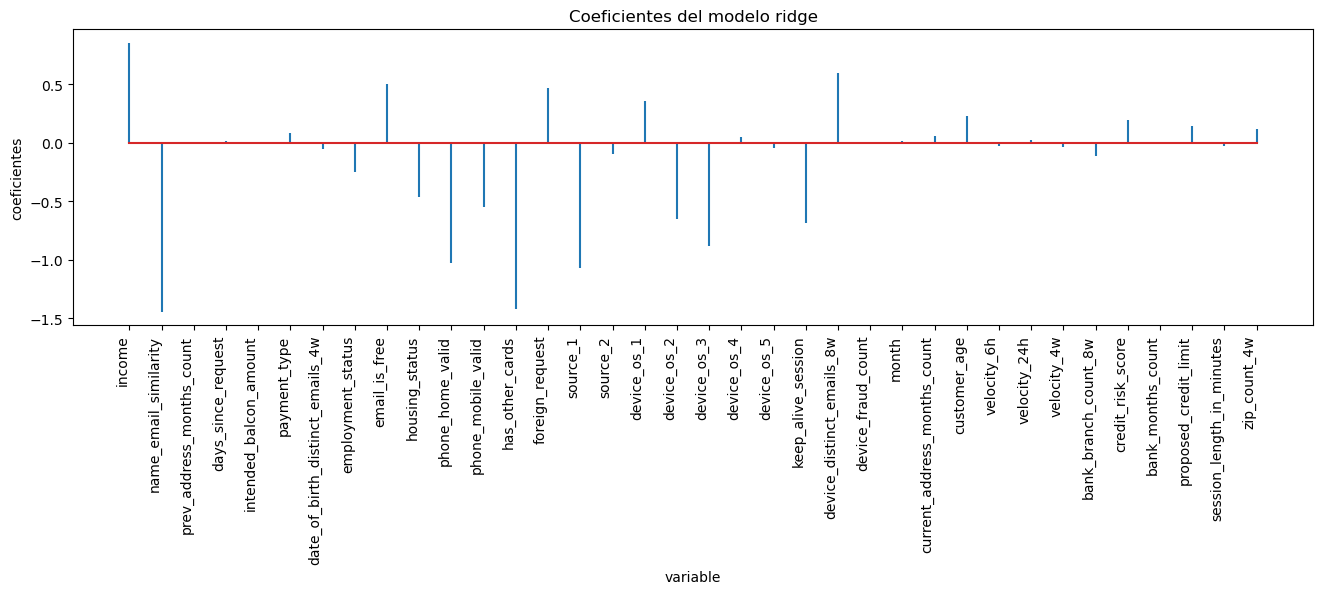

In [10]:
# Hacemos la regularización ridge para seleccionar las variables que más peso tienen dentro de la función a la hora de
# dictaminar cuál será el valor definitivo del target.
df_coeficientes = pd.DataFrame(
                        {'predictor': X.columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [11]:
df_fraud.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'days_since_request',
       'intended_balcon_amount', 'payment_type',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'email_is_free', 'housing_status', 'phone_home_valid',
       'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'source_1',
       'source_2', 'device_os_1', 'device_os_2', 'device_os_3', 'device_os_4',
       'device_os_5', 'keep_alive_session', 'device_distinct_emails_8w',
       'device_fraud_count', 'month', 'current_address_months_count',
       'customer_age', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'credit_risk_score', 'bank_months_count',
       'proposed_credit_limit', 'session_length_in_minutes', 'zip_count_4w'],
      dtype='object')

In [12]:
#Elegimos un thredhold (lo hemos hecho hace tres casillas) de 0.1 y eliminamos más de la mitad de las variables
sel_ridge.get_support()
selected_features_Ridge = X.columns[sel_ridge.get_support()]
print('variables totales: {}'.format((X_train0.shape[1])))
print('variables elegidas: {}'.format(len(selected_features_Ridge)))
selected_features_Ridge

variables totales: 36
variables elegidas: 20


Index(['income', 'name_email_similarity', 'employment_status', 'email_is_free',
       'housing_status', 'phone_home_valid', 'phone_mobile_valid',
       'has_other_cards', 'foreign_request', 'source_1', 'device_os_1',
       'device_os_2', 'device_os_3', 'keep_alive_session',
       'device_distinct_emails_8w', 'customer_age', 'bank_branch_count_8w',
       'credit_risk_score', 'proposed_credit_limit', 'zip_count_4w'],
      dtype='object')

El modelo de selección Ridge ha seleccionado 20 variables de 36 y están guardadas dentreo de una lista llamada "selected_features_Ridge" que será utilizada posteriormente.

### Random Forest

In [13]:
# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=69)

In [14]:
# Entrenar el modelo
rf_model.fit(X_train0, y_train0)

RandomForestClassifier(random_state=69)

In [15]:
y_pred = rf_model.predict(X_test)

In [16]:
# Seleccionar variables importantes usando el modelo entrenado
feature_selector = SelectFromModel(rf_model, threshold='median')
feature_selector.fit(X_train0, y_train0)

SelectFromModel(estimator=RandomForestClassifier(random_state=69),
                threshold='median')

In [17]:
# Estas son las variables que seleccionamos tras aplicar el árbol de decisión. 
selected_features_RF = X.columns[feature_selector.get_support()]

In [18]:
selected_features_RF

Index(['income', 'name_email_similarity', 'days_since_request',
       'intended_balcon_amount', 'date_of_birth_distinct_emails_4w',
       'housing_status', 'month', 'current_address_months_count',
       'customer_age', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'credit_risk_score', 'bank_months_count',
       'proposed_credit_limit', 'session_length_in_minutes', 'zip_count_4w'],
      dtype='object')

El modelo de Random Forest ha seleccionado 19 variables de 36 y están guardadas dentreo de una lista llamada "selected_features_RF" que será utilizada posteriormente.

### Guardamos un nuevo dataframe con las variables seleccionadas

Unificamos las dos listas que hemos obtenido con cada modelo de selección para quedarnos con una lista única sin variables repetidas.

In [19]:
#Combinamos las variables elegidas por cada uno de los dos modelos.
all_selected_features = list(set(selected_features_Ridge))
all_selected_features.extend(selected_features_RF)
all_selected_features

['device_os_1',
 'phone_mobile_valid',
 'device_os_3',
 'zip_count_4w',
 'foreign_request',
 'has_other_cards',
 'proposed_credit_limit',
 'income',
 'keep_alive_session',
 'credit_risk_score',
 'name_email_similarity',
 'device_os_2',
 'bank_branch_count_8w',
 'phone_home_valid',
 'device_distinct_emails_8w',
 'employment_status',
 'email_is_free',
 'source_1',
 'housing_status',
 'customer_age',
 'income',
 'name_email_similarity',
 'days_since_request',
 'intended_balcon_amount',
 'date_of_birth_distinct_emails_4w',
 'housing_status',
 'month',
 'current_address_months_count',
 'customer_age',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'credit_risk_score',
 'bank_months_count',
 'proposed_credit_limit',
 'session_length_in_minutes',
 'zip_count_4w']

In [20]:
#Creamos un df donde estén las variables elegidas por alguno de los dos métodos, o ridge o el árbol de decisión
X_train_seleccionado = X_train0[all_selected_features]
X_test_seleccionado = X_test[all_selected_features]

# Número total de columnas seleccionadas
num_selected_columns = len(all_selected_features)

# Excluir la columna 'fraud_bool' al obtener las columnas antes y después de la selección
columnas_originales = set(X_train0.columns)
columnas_seleccionadas = set(X_train_seleccionado.columns)

# Encontrar las columnas eliminadas
columnas_eliminadas = columnas_originales - columnas_seleccionadas

# Número de columnas eliminadas
num_columnas_eliminadas = len(columnas_eliminadas)

print("Número total de columnas seleccionadas:", num_selected_columns)
print("Número de columnas eliminadas:", num_columnas_eliminadas)
print("Nombres de las columnas eliminadas:", list(columnas_eliminadas))

Número total de columnas seleccionadas: 38
Número de columnas eliminadas: 6
Nombres de las columnas eliminadas: ['device_fraud_count', 'source_2', 'device_os_5', 'device_os_4', 'payment_type', 'prev_address_months_count']


Y finalmente guardamos nuestro X_train e X_test mantenteniendo unicamente las variables seleccionadas. En total nuestros modelos han seleccionado 38 variables y eliminado 5. 

Sin embargo, observamos que una de las variables seleccionadas es 'device_os_1', 'device_os_2', 'device_os_3', pero nos elimina 'device_os_4' y 'device_os_5'. Al tratarse de una de las columnas a las que aplicamos el One Hot Encoding, vamos a volver a añadir las columnas 'device_os_4' y 'device_os_5' en lugar de eliminarlas. 

In [21]:
X_train_seleccionado = X_train0[all_selected_features].join(X_train0[['device_os_4', 'device_os_5']])
X_test_seleccionado = X_test[all_selected_features].join(X_test[['device_os_4', 'device_os_5']])

In [22]:
# Número total de columnas seleccionadas
num_selected_columns = len(all_selected_features)

# Excluir la columna 'fraud_bool' al obtener las columnas antes y después de la selección
columnas_originales = set(X_train0.columns)
columnas_seleccionadas = set(X_train_seleccionado.columns)

# Encontrar las columnas eliminadas
columnas_eliminadas = columnas_originales - columnas_seleccionadas

# Número de columnas eliminadas
num_columnas_eliminadas = len(columnas_eliminadas)

print("Número total de columnas seleccionadas:", num_selected_columns)
print("Número de columnas eliminadas:", num_columnas_eliminadas)
print("Nombres de las columnas eliminadas:", list(columnas_eliminadas))

Número total de columnas seleccionadas: 38
Número de columnas eliminadas: 4
Nombres de las columnas eliminadas: ['device_fraud_count', 'source_2', 'payment_type', 'prev_address_months_count']


Por lo tanto, finalmente, hemos eliminado 3 variables con respecto a nuestro dataframe original.

In [23]:
X_train_seleccionado.head()

,device_os_1,phone_mobile_valid,device_os_3,zip_count_4w,foreign_request,has_other_cards,proposed_credit_limit,income,keep_alive_session,credit_risk_score,name_email_similarity,device_os_2,bank_branch_count_8w,phone_home_valid,device_distinct_emails_8w,employment_status,email_is_free,source_1,housing_status,customer_age,income,name_email_similarity,days_since_request,intended_balcon_amount,date_of_birth_distinct_emails_4w,housing_status,month,current_address_months_count,customer_age,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,zip_count_4w,device_os_4,device_os_5
644342,0,0,0,-0.148892,0,0,-0.647820,0.3,1,0.143659,0.736837,1,3.704406,1,1,1,1,1,2,-0.306764,0.3,0.736837,0.017725,-0.768472,23,2,0,-0.459105,-0.306764,2.568422,0.822590,1.918000,3.704406,0.143659,0.756028,-0.647820,-0.629445,-0.148892,0,0
860994,0,1,1,-0.865043,0,0,-0.647820,0.1,0,-1.061821,0.558561,0,-0.398938,1,1,1,1,1,5,1.356328,0.1,0.558561,0.013191,-0.976172,4,5,5,0.219578,1.356328,-0.647138,-0.414845,0.157245,-0.398938,-1.061821,-0.977093,-0.647820,-0.060323,-0.865043,0,0
881721,0,1,0,-0.882947,0,0,0.993005,0.7,0,0.100606,0.871894,1,1.437341,0,1,1,1,1,3,-0.306764,0.7,0.871894,0.020082,-0.960620,20,3,4,-0.821069,-0.306764,1.191220,0.177541,-0.052375,1.437341,0.100606,-0.812033,0.993005,0.366966,-0.882947,0,0
123804,0,1,1,-0.015608,0,0,-0.032511,0.5,0,-0.114658,0.061825,0,-0.364127,1,1,6,0,1,1,-0.306764,0.5,0.061825,0.001984,-0.857114,14,1,3,-0.934183,-0.306764,0.227892,-0.106872,0.036070,-0.364127,-0.114658,0.013262,-0.032511,-0.382172,-0.015608,0,0
321273,1,1,0,-0.062357,0,0,-0.647820,0.1,1,-0.157711,0.193142,0,-0.311910,0,1,1,0,1,3,0.524782,0.1,0.193142,0.002681,-0.561614,12,3,2,1.022686,0.524782,0.407142,2.127220,0.968756,-0.311910,-0.157711,-0.729504,-0.647820,-0.036421,-0.062357,0,0


Renombramos nuestros dataframes obtenidos para poder manipularlos: 

In [24]:
#Tras utilizar como almacén para hacer los cambios, X_train_seleccionado, actualizamos el valor de X_train0 y x_test
X_train0 = X_train_seleccionado 
X_test = X_test_seleccionado 

## Feature engeneering

### Crear variable nueva:

Creamos la variable trimestre (quarter), a partir de la variable del mes, que va, según dicen las instrucciones de la base de datos, desde 0 (enero) hasta 7 (agosto).

In [25]:
def asignar_cuatrimestre(df, mes_columna):
    cuatrimestre_values = {
        0: 1,
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 2,
        6: 3,
        7: 3,
        8: 3,
        9: 4,
        10: 4,
        11: 4
    }

    if mes_columna not in df.columns:
        print(f"La columna '{mes_columna}' no se encuentra en el DataFrame.")
        return None

    df['Quarter'] = df[mes_columna].map(cuatrimestre_values)
    return df    

In [26]:
X_train0.head()

,device_os_1,phone_mobile_valid,device_os_3,zip_count_4w,foreign_request,has_other_cards,proposed_credit_limit,income,keep_alive_session,credit_risk_score,name_email_similarity,device_os_2,bank_branch_count_8w,phone_home_valid,device_distinct_emails_8w,employment_status,email_is_free,source_1,housing_status,customer_age,income,name_email_similarity,days_since_request,intended_balcon_amount,date_of_birth_distinct_emails_4w,housing_status,month,current_address_months_count,customer_age,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,zip_count_4w,device_os_4,device_os_5
644342,0,0,0,-0.148892,0,0,-0.647820,0.3,1,0.143659,0.736837,1,3.704406,1,1,1,1,1,2,-0.306764,0.3,0.736837,0.017725,-0.768472,23,2,0,-0.459105,-0.306764,2.568422,0.822590,1.918000,3.704406,0.143659,0.756028,-0.647820,-0.629445,-0.148892,0,0
860994,0,1,1,-0.865043,0,0,-0.647820,0.1,0,-1.061821,0.558561,0,-0.398938,1,1,1,1,1,5,1.356328,0.1,0.558561,0.013191,-0.976172,4,5,5,0.219578,1.356328,-0.647138,-0.414845,0.157245,-0.398938,-1.061821,-0.977093,-0.647820,-0.060323,-0.865043,0,0
881721,0,1,0,-0.882947,0,0,0.993005,0.7,0,0.100606,0.871894,1,1.437341,0,1,1,1,1,3,-0.306764,0.7,0.871894,0.020082,-0.960620,20,3,4,-0.821069,-0.306764,1.191220,0.177541,-0.052375,1.437341,0.100606,-0.812033,0.993005,0.366966,-0.882947,0,0
123804,0,1,1,-0.015608,0,0,-0.032511,0.5,0,-0.114658,0.061825,0,-0.364127,1,1,6,0,1,1,-0.306764,0.5,0.061825,0.001984,-0.857114,14,1,3,-0.934183,-0.306764,0.227892,-0.106872,0.036070,-0.364127,-0.114658,0.013262,-0.032511,-0.382172,-0.015608,0,0
321273,1,1,0,-0.062357,0,0,-0.647820,0.1,1,-0.157711,0.193142,0,-0.311910,0,1,1,0,1,3,0.524782,0.1,0.193142,0.002681,-0.561614,12,3,2,1.022686,0.524782,0.407142,2.127220,0.968756,-0.311910,-0.157711,-0.729504,-0.647820,-0.036421,-0.062357,0,0


In [27]:
X_train0 = asignar_cuatrimestre(X_train0, "month")
X_test = asignar_cuatrimestre(X_test, "month")

Eliminamos la variable month para evitar problemas de multicolinealidad con la variable trimestre.

In [28]:
# Eliminar la columna 'month' de x_train0
X_train0 = X_train0.drop('month', axis=1)

# Eliminar la columna 'month' de x_test
X_test = X_test.drop('month', axis=1)

In [29]:
X_train0.head()

,device_os_1,phone_mobile_valid,device_os_3,zip_count_4w,foreign_request,has_other_cards,proposed_credit_limit,income,keep_alive_session,credit_risk_score,name_email_similarity,device_os_2,bank_branch_count_8w,phone_home_valid,device_distinct_emails_8w,employment_status,email_is_free,source_1,housing_status,customer_age,income,name_email_similarity,days_since_request,intended_balcon_amount,date_of_birth_distinct_emails_4w,housing_status,current_address_months_count,customer_age,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,zip_count_4w,device_os_4,device_os_5,Quarter
644342,0,0,0,-0.148892,0,0,-0.647820,0.3,1,0.143659,0.736837,1,3.704406,1,1,1,1,1,2,-0.306764,0.3,0.736837,0.017725,-0.768472,23,2,-0.459105,-0.306764,2.568422,0.822590,1.918000,3.704406,0.143659,0.756028,-0.647820,-0.629445,-0.148892,0,0,1
860994,0,1,1,-0.865043,0,0,-0.647820,0.1,0,-1.061821,0.558561,0,-0.398938,1,1,1,1,1,5,1.356328,0.1,0.558561,0.013191,-0.976172,4,5,0.219578,1.356328,-0.647138,-0.414845,0.157245,-0.398938,-1.061821,-0.977093,-0.647820,-0.060323,-0.865043,0,0,2
881721,0,1,0,-0.882947,0,0,0.993005,0.7,0,0.100606,0.871894,1,1.437341,0,1,1,1,1,3,-0.306764,0.7,0.871894,0.020082,-0.960620,20,3,-0.821069,-0.306764,1.191220,0.177541,-0.052375,1.437341,0.100606,-0.812033,0.993005,0.366966,-0.882947,0,0,2
123804,0,1,1,-0.015608,0,0,-0.032511,0.5,0,-0.114658,0.061825,0,-0.364127,1,1,6,0,1,1,-0.306764,0.5,0.061825,0.001984,-0.857114,14,1,-0.934183,-0.306764,0.227892,-0.106872,0.036070,-0.364127,-0.114658,0.013262,-0.032511,-0.382172,-0.015608,0,0,2
321273,1,1,0,-0.062357,0,0,-0.647820,0.1,1,-0.157711,0.193142,0,-0.311910,0,1,1,0,1,3,0.524782,0.1,0.193142,0.002681,-0.561614,12,3,1.022686,0.524782,0.407142,2.127220,0.968756,-0.311910,-0.157711,-0.729504,-0.647820,-0.036421,-0.062357,0,0,1


### División train/validación

Dividimos nuestro train con el que hemos trabajado en train y validación:

In [30]:
X_train1, X_validacion, y_train1, y_validacion = train_test_split(
    X_train0, 
    y_train0, 
    test_size=0.25,  # Ajusta el tamaño según sea necesario (en este caso, 25% para validación)
    random_state=69  # Semilla para reproducibilidad
)

Y observamos como están divididos los datos entre nuestro train, validación y test:

In [31]:
# Obtener la cantidad de filas para cada conjunto
num_rows_train = X_train1.shape[0]
num_rows_validacion = X_validacion.shape[0]
num_rows_test = X_test.shape[0]

# Obtener el total de filas
total_rows = num_rows_train + num_rows_validacion + num_rows_test

# Calcular el porcentaje para cada conjunto
porcentaje_train = (num_rows_train / total_rows) * 100
porcentaje_validacion = (num_rows_validacion / total_rows) * 100
porcentaje_test = (num_rows_test / total_rows) * 100

# Mostrar los resultados
print(f"Porcentaje de datos en 'Train': {porcentaje_train:.2f}%")
print(f"Porcentaje de datos en 'Validación': {porcentaje_validacion:.2f}%")
print(f"Porcentaje de datos en 'Test': {porcentaje_test:.2f}%")

Porcentaje de datos en 'Train': 60.00%
Porcentaje de datos en 'Validación': 20.00%
Porcentaje de datos en 'Test': 20.00%


### Undersampling:

Para reducir tiempos de computación a la hora de ejecutar un problema con un millón de instancias, y para elegir el modelo a utilizar, realizamos undersampling. Ahora el dataset se nos queda en un 60% de entrenamiento que estará rebalanceado, y una validación y test que permanecen vírgenes. Siempre utilizamos el mismo random_state para los splits

In [32]:
# Definir el undersampler con la proporción deseada
undersampler = RandomUnderSampler(sampling_strategy=0.2, random_state=69)

# Aplicar undersampling a X_train e y_train
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train1, y_train1)

# Ver las formas antes y después del undersampling
print("Antes del undersampling - X_train:", X_train1.shape, "y_train:", y_train1.shape)
print("Después del undersampling - X_train_resampled:", X_train_resampled.shape, "y_train_resampled:", y_train_resampled.shape)


Antes del undersampling - X_train: (600000, 40) y_train: (600000,)
Después del undersampling - X_train_resampled: (40098, 40) y_train_resampled: (40098,)


In [33]:
print('== Test\n', y_train_resampled.value_counts(normalize=True))

== Test
 fraud_bool
0    0.833333
1    0.166667
Name: proportion, dtype: float64


In [34]:
X_train1 = X_train_resampled
y_train1 = y_train_resampled 

### Guardamos dataframes relevantes

In [35]:
X_train0.to_csv("../data/X_train0.csv")
y_train0.to_csv("../data/y_train0.csv")
X_train1.to_csv("../data/X_train1.csv")
X_test.to_csv("../data/X_test.csv")
y_train1.to_csv("../data/y_train1.csv")
y_test.to_csv("../data/y_test.csv")
X_validacion.to_csv("../data/X_validacion.csv")
y_validacion.to_csv("../data/y_validacion.csv")